# [1] 데이터 분석 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 코드 간결화
# 부동산, 고도, 이동 거리에 따른 시간을 수치화 할 수 있는 방법
# ex) 이동 시간(y) = A이동거리(x) + B (A,B : 부동산, 고도)
# 인구 예측 수식 고도화
# 주석 필수

# 목차 정리를 추가하였습니다.
# 코드 간결화
# 부동산, 고도, 이동 거리에 따른 시간을 수치화 할 수 있는 방법
# ex) 이동 시간(y) = A이동거리(x) + B (A,B : 부동산, 고도)
# 인구 예측 수식 고도화
# 주석 필수



경로당의 기존 설치 기준은  설비와 관련된 사항만 고려하여 
__고령인구, 이용률, 접근성을 전혀 고려하지 않는다.__

현행: 다음과 같은 기준을 만족한다면 구청장의 허가를 통해 설치가 가능하다.

- 이용정원 20명 이상(읍·면지역의 경우 10명 이상)
- 거실 또는 휴게실 : 20$m^2$ 이상.(6평 이상)
- 건축법에 의한 노유자시설

우리들은 __고령인구, 이용률, 접근성의 삼박자를 갖춘
최적의 시니어 센터 입지 분석 및 제안함__



관련 라이브러리 설치 및 버전 수정

In [ ]:
# OSMnx 설치
!pip install osmnx 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 95 kB 2.9 MB/s 
     |████████████████████████████████| 63 kB 1.6 MB/s 
     |████████████████████████████████| 11.2 MB 47.0 MB/s 
     |████████████████████████████████| 1.0 MB 47.3 MB/s 
     |████████████████████████████████| 6.3 MB 37.5 MB/s 
     |████████████████████████████████| 1.0 MB 54.2 MB/s 
     |████████████████████████████████| 16.7 MB 287 kB/s 
     |████████████████████████████████| 930 kB 30.9 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. Th

차트의 한글이 깨지면 아래 셀을 실행 후 런타임 -> 런타임 다시 시작 -> Ctrl + F9 

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 42 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 1s (8,472 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletyp

관련 라이브러리 import

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import osmnx as ox
import geopandas as gpd
from descartes import PolygonPatch
from shapely.geometry import LineString
from shapely.geometry import Point
from shapely.geometry import Polygon

## 1) 데이터 로드 - 부산광역시 인구 현황, 경로당 현황 및 경로당 이용률
----

사용된 데이터 셋
- 2021년_부산_인구_현황.csv
- 2021년_부산_경로당_현황.csv
- 부산_경로당_이용률.csv

In [ ]:
df_population = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/OSS/Data_Analytics_for_Age_friendly_busan-seungmin/data/부산-50~100.csv",encoding='cp949')
df_population.head(5)

,행정구역(동읍면)별,합계,50 - 54세,55 - 59세,60 - 64세,65 - 69세,70 - 74세,75 - 79세,80 - 84세,85 - 89세,90 - 94세,95 - 99세,100+,고령인구 합계,구간 합계
0,부산광역시,3356311,284015,271887,305573,242157,173938,122955,83699,38587,12632,2565,681,677214,1538689
1,중구,40676,3386,3387,4202,3692,2773,2180,1484,661,260,62,16,11128,22103
2,중앙동,2865,193,174,200,176,112,78,54,30,13,3,0,466,1033
3,동광동,2684,228,244,304,255,237,191,129,61,28,6,1,908,1684
4,대청동,6298,508,522,676,497,404,346,206,95,52,13,2,1615,3321


부산_경로당_이용률.csv 로드

In [ ]:
df_sc_members = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/OSS/Data_Analytics_for_Age_friendly_busan-seungmin/data/경로당 등록자 수.csv",encoding='UTF-8')
df_sc_members.head(5)

,구분,경로당 1개소 당 등록자 수,전체 노인 중 경로당 이용 비율,전체 인구 중 노인 비율
0,중구,43.2,12.5,24.2
1,서구,26.2,7.6,22.8
2,동구,30.7,9.6,24.6
3,영도구,35.2,8.1,24.2
4,부산진구,31.9,15.0,17.8


In [ ]:
# 칼럼 분석 - 지역별로 노인 나잇대의 분포를 나타내는 파일
df_population.columns

Index(['행정구역(동읍면)별', '합계', '50 - 54세', '55 - 59세', '60 - 64세', '65 - 69세',
       '70 - 74세', '75 - 79세', '80 - 84세', '85 - 89세', '90 - 94세', '95 - 99세',
       '100+', '고령인구 합계', '구간 합계'],
      dtype='object')

2021_부산_경로당_현황.csv 로드

In [ ]:
df_busan_senior_centers = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/OSS/Data_Analytics_for_Age_friendly_busan-seungmin/data/부산광역시_경로당현황_2021.csv",encoding='cp949')
df_busan_senior_centers.head(5)

,관리기관명,경로당명,소재지,연락처,위도,경도,X좌표,Y좌표,읍면동
0,중구,중앙동경로당,부산광역시 중구 중앙대로115번길 1-6,051-468-9982,35.107847,129.035834,1139967.538,1680263.547,중앙동
1,중구,동광동경로당,부산광역시 중구 샘길 12,051-463-1936,35.106433,129.032937,1139707.362,1680106.115,대청동
2,중구,동광동할머니경로당,부산광역시 중구 동광길111번길 11,051-468-5226,35.107908,129.035004,1139893.576,1680274.849,동광동
3,중구,대청만우경로당,부산광역시 중구 중구로91번안길 15,051-469-8070,35.105218,129.029732,1139416.849,1679966.393,대청동
4,중구,대청화목경로당,부산광역시 중구 대청북길 14,051-463-1535,35.105313,129.028792,1139331.558,1679976.204,대청동


데이터를 분석

In [ ]:
# df_population - 인구 현황
# df_sc_members - 경로당 이용률
# df_busan_senior_centers - 경로당 현황

In [ ]:
print(df_population.shape)
print(df_sc_members.shape)
print(df_busan_senior_centers.shape)

(222, 15)
(16, 4)
(2310, 9)


In [ ]:
print("부산 인구 현황:",df_population.columns,'\n')
print("부산 경로당 통계:",df_sc_members.columns,'\n')
print("부산 경로당 정보:",df_busan_senior_centers.columns)

부산 인구 현황: Index(['행정구역(동읍면)별', '합계', '50 - 54세', '55 - 59세', '60 - 64세', '65 - 69세',
       '70 - 74세', '75 - 79세', '80 - 84세', '85 - 89세', '90 - 94세', '95 - 99세',
       '100+', '고령인구 합계', '구간 합계'],
      dtype='object') 

부산 경로당 통계: Index(['구분', '경로당 1개소 당 등록자 수', '전체 노인 중 경로당 이용 비율', '전체 인구 중 노인 비율'], dtype='object') 

부산 경로당 정보: Index(['관리기관명', '경로당명', '소재지', '연락처', '위도', '경도', 'X좌표', 'Y좌표', '읍면동'], dtype='object')


In [ ]:
df_sc_members.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   구분                 16 non-null     object 
 1   경로당 1개소 당 등록자 수    16 non-null     float64
 2   전체 노인 중 경로당 이용 비율  16 non-null     float64
 3   전체 인구 중 노인 비율      16 non-null     float64
dtypes: float64(3), object(1)
memory usage: 640.0+ bytes


In [ ]:
df_population

,행정구역(동읍면)별,합계,50 - 54세,55 - 59세,60 - 64세,65 - 69세,70 - 74세,75 - 79세,80 - 84세,85 - 89세,90 - 94세,95 - 99세,100+,고령인구 합계,구간 합계
0,부산광역시,3356311,284015,271887,305573,242157,173938,122955,83699,38587,12632,2565,681,677214,1538689
1,중구,40676,3386,3387,4202,3692,2773,2180,1484,661,260,62,16,11128,22103
2,중앙동,2865,193,174,200,176,112,78,54,30,13,3,0,466,1033
3,동광동,2684,228,244,304,255,237,191,129,61,28,6,1,908,1684
4,대청동,6298,508,522,676,497,404,346,206,95,52,13,2,1615,3321
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217,기장읍,52793,4938,4493,4771,3738,2852,2221,1596,775,249,68,11,11510,25712
218,장안읍,8598,710,792,947,756,538,412,328,190,70,20,5,2319,4768
219,정관읍,81798,5350,3487,3745,3309,2413,1604,972,469,154,43,5,8969,21551
220,일광면,25805,1947,1849,1931,1330,989,630,410,253,83,21,5,3721,9448


In [ ]:
# 인구 현황 파일의 데이터 칼럼타입
df_population.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 222 entries, 0 to 221
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   행정구역(동읍면)별  222 non-null    object
 1   합계          222 non-null    int64 
 2   50 - 54세    222 non-null    int64 
 3   55 - 59세    222 non-null    int64 
 4   60 - 64세    222 non-null    int64 
 5   65 - 69세    222 non-null    int64 
 6   70 - 74세    222 non-null    int64 
 7   75 - 79세    222 non-null    int64 
 8   80 - 84세    222 non-null    int64 
 9   85 - 89세    222 non-null    int64 
 10  90 - 94세    222 non-null    int64 
 11  95 - 99세    222 non-null    int64 
 12  100+        222 non-null    int64 
 13  고령인구 합계     222 non-null    int64 
 14  구간 합계       222 non-null    int64 
dtypes: int64(14), object(1)
memory usage: 26.1+ KB


In [ ]:
df_busan_senior_centers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2310 entries, 0 to 2309
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   관리기관명   2310 non-null   object 
 1   경로당명    2309 non-null   object 
 2   소재지     2309 non-null   object 
 3   연락처     1980 non-null   object 
 4   위도      2308 non-null   float64
 5   경도      2308 non-null   float64
 6   X좌표     2309 non-null   float64
 7   Y좌표     2309 non-null   float64
 8   읍면동     2310 non-null   object 
dtypes: float64(4), object(5)
memory usage: 162.5+ KB


In [ ]:
#
df_sc_members

,구분,경로당 1개소 당 등록자 수,전체 노인 중 경로당 이용 비율,전체 인구 중 노인 비율
0,중구,43.2,12.5,24.2
1,서구,26.2,7.6,22.8
2,동구,30.7,9.6,24.6
3,영도구,35.2,8.1,24.2
4,부산진구,31.9,15.0,17.8
5,동래구,39.8,13.0,16.6
6,남구,34.0,10.0,17.9
7,북구,29.9,10.4,14.5
8,해운대구,39.9,14.2,15.3
9,사하구,26.5,9.3,16.1


## 2) 적절한 경로당 수, 필요한 경로당 수를 파악하기 위해 새로운 데이터 프레임 생성
---

행정 구 단위 경로당을 추출 및 행정 구역 데이터 로드

데이터 프레임 컬럼 구조

행정 구 | 행정 동 | 경로당 수 | 적절한 경로당 수 | 필요한 경로당 수 |

In [ ]:
district = ["강서구", "금정구","기장군","남구","동구","동래구","부산진구","북구","사상구","사하구","서구","수영구","연제구","영도구","중구","해운대구"]

### 2.1) 새로운 데이터 프레임 생성 메서드

In [ ]:
def get_senior_centers_by_district():
    '''
    구별로 시니어 센터를가져옴. 구.csv파일 읽음
    :return: 행정구 | 행정 동 | 경로당 수 | 적절한 경로당 수 | 필요한 경로당 수 |
    '''
    df_temp = pd.DataFrame(columns=["경로당 수", "적절한 경로당 수", "필요한 경로당 수"])
    #  구, 동에 대한 정보 불러옴
    df_district = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/OSS/Data_Analytics_for_Age_friendly_busan-seungmin/data/구.csv", encoding='cp949')
    df = pd.concat([df_district , df_temp])

    return df

In [ ]:
df_main =get_senior_centers_by_district()
df_main.head(5)

,행정 구,행정 동,경로당 수,적절한 경로당 수,필요한 경로당 수
0,중구,중앙동,NaN,NaN,NaN
1,중구,동광동,NaN,NaN,NaN
2,중구,대청동,NaN,NaN,NaN
3,중구,보수동,NaN,NaN,NaN
4,중구,부평동,NaN,NaN,NaN


## 3) 행정 동 단위 고령인구를 파악
---

각 행정 동 단위 적절한 경로당 수 및 필요한 경로당 수를 파악하기 위해 행정 동 단위 고령인구를 파악해야한다.

### 3.1) 행정 동 단위 고령인구 추출 메서드

In [ ]:
df_population[['합계','50 - 54세']]

,합계,50 - 54세
0,3356311,284015
1,40676,3386
2,2865,193
3,2684,228
4,6298,508
...,...,...
217,52793,4938
218,8598,710
219,81798,5350
220,25805,1947


In [ ]:
df_population["행정구역(동읍면)별"]

0      부산광역시
1         중구
2        중앙동
3        동광동
4        대청동
       ...  
217      기장읍
218      장안읍
219      정관읍
220      일광면
221      철마면
Name: 행정구역(동읍면)별, Length: 222, dtype: object

In [ ]:
df_population["고령인구 합계"]

0      677214
1       11128
2         466
3         908
4        1615
        ...  
217     11510
218      2319
219      8969
220      3721
221      2526
Name: 고령인구 합계, Length: 222, dtype: int64

In [ ]:
lst_df = [df_population["행정구역(동읍면)별"],df_population["고령인구 합계"]]

In [ ]:
lst_df

[0      부산광역시
 1         중구
 2        중앙동
 3        동광동
 4        대청동
        ...  
 217      기장읍
 218      장안읍
 219      정관읍
 220      일광면
 221      철마면
 Name: 행정구역(동읍면)별, Length: 222, dtype: object, 0      677214
 1       11128
 2         466
 3         908
 4        1615
         ...  
 217     11510
 218      2319
 219      8969
 220      3721
 221      2526
 Name: 고령인구 합계, Length: 222, dtype: int64]

In [ ]:
df_sc = pd.concat(lst_df,axis=1)

In [ ]:
df_sc

,행정구역(동읍면)별,고령인구 합계
0,부산광역시,677214
1,중구,11128
2,중앙동,466
3,동광동,908
4,대청동,1615
...,...,...
217,기장읍,11510
218,장안읍,2319
219,정관읍,8969
220,일광면,3721


In [ ]:

def get_senior_people_by_admin_area(district):
    '''
    행정구역별 고령인구 가져옴
    :return: 행정구역별 | 고령인구 합계
    '''
    
    #lst_df = [df_population["행정구역(동읍면)별"],df_population["고령인구 합계"]]
    #df_sc = pd.concat(lst_df,axis=1)
    #위 두 줄을 밑의 한줄로 간결화
    df_sc = df_population[["행정구역(동읍면)별","고령인구 합계"]].copy()
    
    
    lst = []
    for i in range(1,222): # 222 : number_of_record
        for d in district:
            if df_sc.iloc[i]["행정구역(동읍면)별"] == d:
                lst.append(i)

    for i in lst:
        df_sc.drop(index=i,axis=0,inplace=True) # 행정 구 삭제
    df_sc .drop(index=0,inplace=True)  # 부산광역시 전체 삭제
    df_sc.set_index("행정구역(동읍면)별",inplace=True) # 동을 기준으로 함
    return df_sc.copy()

In [ ]:
df_senior_people = get_senior_people_by_admin_area(district)
df_senior_people.head(5)

,고령인구 합계
행정구역(동읍면)별,
중앙동,466
동광동,908
대청동,1615
보수동,2808
부평동,1377


In [ ]:
df_old_population_count  = df_senior_people .sort_index()
df_old_population_count.head(5)

,고령인구 합계
행정구역(동읍면)별,
가덕도동,1183
가락동,928
가야1동,4339
가야2동,3888
감만1동,3430


### 3.2) 노인 1명당 경로당 수 산출 메서드

In [ ]:
def oen_old_population_senior_centers(df_busan_senior_centers,df_population):
    '''
     부산 전체 경로당 수 / 부산 전체 고령인구 수
    :param df_busan_senior_centers:  부산 전체 경로당 수
    :param df_population: 부산 전체 고령인구 수
    :return: 노인 1명당 경로당 수
    '''
    busan_senior_centers = df_busan_senior_centers.shape[0] # 부산 전체 경로당 수
    old_population_count = df_population.iloc[0]["고령인구 합계"] # 부산 전체 고령인구
    oen_old_population_senior_center = (busan_senior_centers / old_population_count)
    return oen_old_population_senior_center

In [ ]:
oen_old_population_senior_center = oen_old_population_senior_centers(df_busan_senior_centers,df_population)
oen_old_population_senior_center

0.003411034030601848

### 3.3) 행정 동 단위 적절한 경로당 수 산출 메서드
----

노인 1명당 경로당 수를 파악하여 행정 동 단위 고령인구와 곱한다.

$ 행정\, 동\, 단위\, 적절한\, 경로당\, 수\, =\, 노인\, 1명당\, 경로당\, 수\, *\, 행정\, 동\, 단위\, 고령인구\, $


In [ ]:

def old_population_sum_by_admin_area(df_old_population_count,oen_old_population_senior_center):
    '''
    각 행정 동 고령 인구 합계를 구한 후 이를 이용하여 적절한 경로당 수 구한다
    :param df_old_population_count: 행정 동 단위 고령인구
    :param oen_old_population_senior_center: 노인 1명당 경로당 수
    :return: 적절한 경로당 수
    '''

    row_n = df_old_population_count.shape[0]
    old_people_admin_area = np.array([])
    for i in range(0,row_n):
        old_people_admin_area=np.append(old_people_admin_area,df_old_population_count .iloc[i]["고령인구 합계"])
    old_people_admin_area = old_people_admin_area.astype(int)
    proper_senior_center_n = np.round(old_people_admin_area*oen_old_population_senior_center,1)
    return  proper_senior_center_n#적절한 경로당 수

In [ ]:
proper_senior_center_n = old_population_sum_by_admin_area(df_old_population_count,oen_old_population_senior_center)
proper_senior_center_n

array([ 4. ,  3.2, 14.8, 13.3, 11.7,  6.8, 10.6, 15.5,  7.6,  5.1,  9.3,
        8.8, 19.3, 17.2,  7.1,  9.7,  7.4,  1.1, 16.8, 12.9,  7.4,  9.7,
       12.4, 16.2, 11.7, 11.5,  9.7, 12. , 22. ,  6. , 11. , 16.4, 12.7,
       30. ,  8. ,  0.9, 39.3,  5.8, 10.3, 23. , 10.2,  8.5,  1.1, 11.6,
       13.9, 23.5, 19.4, 17.5,  7.2,  8.4, 18.7, 12.1, 14.4,  9.8, 11.7,
        8. ,  7.5,  5.8,  5.5, 10.4,  9.5,  9.7,  6.2,  8.8,  3.1,  4.6,
        7.8,  6.3, 23.1,  3.3, 11.9,  9.8, 16.2, 12.8, 23.9,  8.7, 11.5,
       11. , 11.6, 12.7,  7.8, 19.5, 12.9, 10.6,  7.2, 10.5,  7.9, 19.2,
       15.1, 24.5, 18.4, 11.7,  8.5,  8.7, 12.4,  5.8,  3.6,  7.1, 16.1,
        9.6, 10. ,  6.9,  7.2,  9. , 12.1, 10.3, 11.7,  5.1, 14.1, 11.4,
       10.2,  4.6,  4.7,  7.2, 11.6, 11.5,  5.1,  5.9,  8.3, 10.9,  9.5,
        5.9,  5.3,  2.6,  8.5, 21.4, 15. ,  4. ,  9.6,  5. ,  6.1, 10.2,
       12.5,  8.6,  8.1, 12.4, 17.7, 11.2, 13.8,  6.9, 13. , 11.4, 13.2,
        7.4, 13.4,  9.2, 14.4,  9.1, 23. , 15.9,  4

### 3.4) 행정 동 단위 필요한 경로당 수 파악
----

적절한 경로당 수와 기존에 설치된 경로당 수를 이용하여 필요한 경로당 수를 이용해 계산

$ 필요한\,경로당\,수\, =\,  -(기존에\, 설치된\, 경로당\, 수\, - 적절한\, 경로당\, 수) $

결과 값에 음수를 취하는 이유는 포화 상태 여부를 강조하기 위함

~~~
if 필요한 경로당 수  <  0  then
        경로당 수 포화
    else 
        증설할 경로당 수 
    endif
~~~



In [ ]:
df_main = df_main.sort_values(by=['행정 동'])
df_busan_senior_centers = df_busan_senior_centers.sort_values(by=["읍면동"])

### 3.5) 행정 동 단위 해당하는 경로당의 수 추출

In [ ]:
# 각 행정 동에 해당하는 경로당의 수를 추출
data = df_busan_senior_centers["읍면동"].value_counts().sort_index()
senior_center_by_admin_area = np.array(data)

### 3.6) 필요한 경로당 수 산출 메서드

In [ ]:

def senior_center_need_counts_by_admin_area(df_main,senior_center_by_admin_area,proper_senior_center_n):
    '''
    읍면동 경로당 수 및 적절한 경로당 수를 이용하여 필요한 경로당 수 구한다.
    :param df_main: 데이터를 삽입할 데이터 프레임
    :param senior_center_by_admin_area: 읍면동의 경로당 수
    :param proper_senior_center_n: 적절한 경로당 수
    :return: 필요한 경로당 수
    '''
    idx_lst = ["행정 구","행정 동"]
    df_main["경로당 수"] = senior_center_by_admin_area
    df_main["적절한 경로당 수"] = proper_senior_center_n
    df_main.loc[df_main.iloc[0:][idx_lst[1]] == "광복동", "경로당 수"] = 0
    #df_main.loc[df_main.iloc[0:][idx_lst[1]]=="광복동","경로당 수"] = 0
    df_main["필요한 경로당 수"] = -(df_main["경로당 수"] - df_main["적절한 경로당 수"])
    df_main = df_main.sort_index()
    df_main = df_main.set_index(idx_lst)

    return df_main

In [ ]:
df_main = senior_center_need_counts_by_admin_area(df_main,senior_center_by_admin_area,proper_senior_center_n)
df_main

KeyError: ignored

## 4) 필요한 정보 구하기

- 경로당 이용률을 고려한 적정 경로당 수 및 필요한 경로당 수 구하기
--------

이용률을 고려하지 않은 결과 
 __고령 인구가 많이 없는 지역의 실제 경로당 수와 적절한 경로당 수의 차이가 매우 심각하게 나타나는 현상 발견__


이에 따른 원인을 분석한 결과 경로당 이용률에 대한 차이가 클 것이다는 가정을 세웠다. 

이용률을 고려하여 노인 1명당 필요한 경로당 수를 다시 산출해야한다.

$ 노인\,1명당\,필요한\,경로당\,수\, =(\,전체\,노인\,중\,경로당\,이용\,비율/100) \,/\,경로당\,1개소\,당\,등록자\,수\,$

### 4.1) 노인 1명당 필요한 경로당 수 산출 메서드

In [ ]:
def oen_old_population_senior_centers_request_by_member(df_sc_members):
    '''
    이용률을 고려한 1명의 노인당 필요한 경로당 개수를 구하여 경로당 이용률 데이터 프레임에 삽입
    :param df_sc_members: 경로당 이용률 데이터 프레임
    :return: 1명의 노인이 필요한 경로당 수
    '''

    sc_members_rate = df_sc_members.iloc[0:]["전체 노인 중 경로당 이용 비율"] # A
    sc_member_n = df_sc_members.iloc[0:]["경로당 1개소 당 등록자 수"] # B
    result = (sc_members_rate/100) / sc_member_n
    df = pd.concat([df_sc_members,result],axis=1)
    df.rename(columns={0:'노인 1명이 필요한 경로당 개수'},inplace=True)

    return df

In [ ]:
df_sc_members = oen_old_population_senior_centers_request_by_member(df_sc_members)
df_request_member_main = get_senior_centers_by_district()
district = list(df_request_member_main.iloc[0:]["행정 구"])
df_request_member_main = df_request_member_main.set_index(["행정 구","행정 동"])

In [ ]:
df_sc_members

,구분,경로당 1개소 당 등록자 수,전체 노인 중 경로당 이용 비율,전체 인구 중 노인 비율,노인 1명이 필요한 경로당 개수
0,중구,43.2,12.5,24.2,0.002894
1,서구,26.2,7.6,22.8,0.002901
2,동구,30.7,9.6,24.6,0.003127
3,영도구,35.2,8.1,24.2,0.002301
4,부산진구,31.9,15.0,17.8,0.004702
5,동래구,39.8,13.0,16.6,0.003266
6,남구,34.0,10.0,17.9,0.002941
7,북구,29.9,10.4,14.5,0.003478
8,해운대구,39.9,14.2,15.3,0.003559
9,사하구,26.5,9.3,16.1,0.003509


In [ ]:
df_request_member_main.head(5)

경로당 수 적절한 경로당 수 필요한 경로당 수
행정 구 행정 동                          
중구   중앙동    NaN       NaN       NaN
     동광동    NaN       NaN       NaN
     대청동    NaN       NaN       NaN
     보수동    NaN       NaN       NaN
     부평동    NaN       NaN       NaN

###4.2) 행정 동 단위 적절한 경로당 수 산출 메서드

In [ ]:
def old_population_sum_by_admin_area_advance(df_request_member_main,df_senior_people,df_sc_members):
    '''
    행정 동 별 적절한 경로당 수를 구한다.
    :param df_request_member_main: 이용률을 고려한 데이터를 담을 df
    :param df_senior_people: 행정 동 단위 고령인구
    :param df_sc_members: 노인 1명당 필요한 경로당 개수 정보
    :return: 적절한 경로당 수가 추가된 데이터 프레임
    '''
    df_sc_members.set_index("구분",inplace=True)
    appropriate_data = np.array([])
    dong_n = df_senior_people.shape[0]
    gu_n = df_sc_members.shape[0]
    str_info = "고령인구 합계"
    for i in range(0,gu_n):
        for j in range(0,dong_n):
            if df_request_member_main.index[j][0] == df_sc_members.index[i]:
                appropriate_data= np.append(
                    appropriate_data,
                    round(df_sc_members.iloc[i]["노인 1명이 필요한 경로당 개수"]*df_senior_people.iloc[j][str_info],1)
                )
                #print(f"result[i]:{df_sc_members.index[i]} 고령:{df_senior_people.iloc[j][str_info]} ")

    df_request_member_main["적절한 경로당 수"] = appropriate_data
    return df_request_member_main

In [ ]:
df_request_member_main= old_population_sum_by_admin_area_advance(
    df_request_member_main,
    df_senior_people,
    df_sc_members
)

In [ ]:
df_request_member_main.head(5)

경로당 수  적절한 경로당 수 필요한 경로당 수
행정 구 행정 동                           
중구   중앙동    NaN        1.3       NaN
     동광동    NaN        2.6       NaN
     대청동    NaN        4.7       NaN
     보수동    NaN        8.1       NaN
     부평동    NaN        4.0       NaN

###4.3) 행정 동 단위 해당하는 경로당 수 및 필요한 경로당 수 산출 메서드

In [ ]:
def senior_center_need_counts_by_admin_area_advance(df_busan_senior_centers,df_request_member_main):
    '''
    행정 동 단위 이용률을 고려한 경로당 개수를 구한다
    :param df_busan_senior_centers: 부산시 경로당 현황 데이터
    :param df_request_member_main:  이용률을 고려한 데이터를 담을 df
    :return: 행정 동 단위 이용률을 고려한 경로당 개수를 담은 df
    '''
    sc_n_by_admin_area = np.array(df_busan_senior_centers["읍면동"].value_counts().sort_index())
    df_request_member_main.reset_index(inplace=True)
    df_request_member_main.sort_values(by=["행정 동"],inplace=True)
    df_request_member_main["경로당 수"] = sc_n_by_admin_area
    df_request_member_main.loc[df_request_member_main.iloc[0:]["행정 동"]=="광복동","경로당 수"] = 0
    df_request_member_main["필요한 경로당 수"] = round(-(df_request_member_main["경로당 수"] - df_request_member_main["적절한 경로당 수"]),0)
    # df_request_member_main.set_index(["행정 구"],inplace=True)

    return df_request_member_main

In [ ]:
df_request_member_main = senior_center_need_counts_by_admin_area_advance(df_busan_senior_centers, df_request_member_main)
df_request_member_main.head(5)

,행정 구,행정 동,경로당 수,적절한 경로당 수,필요한 경로당 수
165,강서구,가덕도동,17,13.4,-4.0
162,강서구,가락동,18,10.6,-7.0
58,부산진구,가야1동,15,20.4,5.0
59,부산진구,가야2동,12,18.3,6.0
88,남구,감만1동,15,10.1,-5.0


In [ ]:
# 예측 평가를 위해 파일 저장
df_request_member_main.to_csv("예측비교.csv",encoding='cp949')

In [ ]:
def extract_by_district_necessary_senior_center(df_request_member_main):
    '''
    df_request_member_main에서 행정 구, 행정 동, 필요한 경로당 수를 추출하여 새로운 데이터 프레임을 생성한다.
    :param df_request_member_main: 추출할 데이터가 들어잇는 데이터 프레임
    :return: 추출된 데이터를 가질 데이터 프레임
    '''
    df = df_request_member_main.sort_index()
    df.drop(columns=["경로당 수","적절한 경로당 수"],axis=1,inplace=True)
    return df

In [ ]:
df_extract_main = extract_by_district_necessary_senior_center(df_request_member_main)
df_extract_main.head(5)

,행정 구,행정 동,필요한 경로당 수
0,중구,중앙동,0.0
1,중구,동광동,2.0
2,중구,대청동,1.0
3,중구,보수동,-2.0
4,중구,부평동,2.0


##5) 시각화, 2001년 ~ 2020년 부산 고령인구 증가 추세 파악
-----


* 2021년의 데이터를 반영하지 않은 이유는 2021년이 아직 지나지 않아 실제 고령인구 수의 변화가 있을 것 이라고 판단하였기 때문임



In [ ]:
rate_df = pd.read_csv("부산-비율.csv",encoding='cp949')

FileNotFoundError: ignored

### 5.1) 고령인구 증가 추세 시각화

In [ ]:
# seaborn 한글 설정
sns.set(font="NanumBarunGothic",
        rc={"axes.unicode_minus":False},
        style='darkgrid')

### 5.2) 시각화 데이터 추출

In [ ]:
orginal = []
last = []
row_n = rate_df.shape[1]

for i in range(0,row_n):
    if i % 2 == 0:
        orginal.append(rate_df.iloc[1][i])
    else:
        last.append(rate_df.iloc[1][i])
orginal = list(map(float,orginal))
last = list(map(float,last))

year = ['2001','2002','2003','2004','2005','2006','2007','2008','2009','2010','2011','2012','2013','2014', '2015', '2016', '2017', '2018', '2019', '2020']
year = list(map(int,year))

### 5.3) 고령인구 증가율 시각화

Text(0, 0.5, '증가 비율')

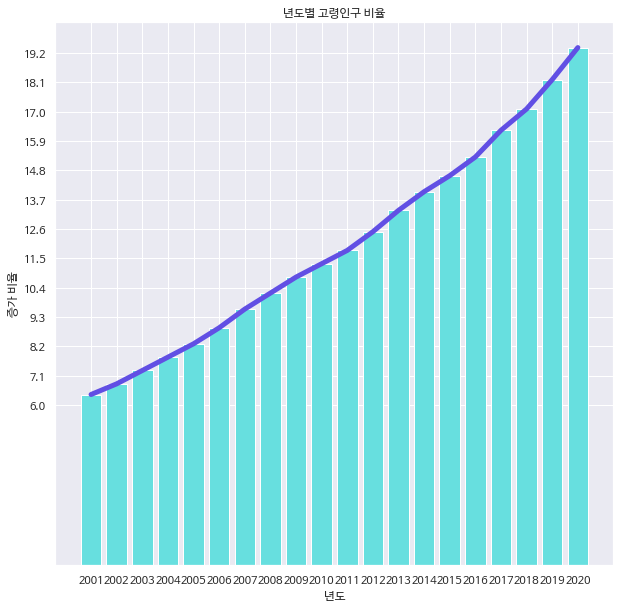

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)

ax.bar(year,orginal,color = '#67DFDF')
ax.plot(year,orginal,color = '#614FE4',linewidth=5.0)

plt.yticks([i for i in np.arange(6.0,20.0,1.1)])
plt.xticks([i for i in range(2001,2021,1)])
plt.title("년도별 고령인구 비율")
plt.xlabel("년도")
ax.set_ylabel("증가 비율")

In [ ]:
rate_df = rate_df.T # 전치

### 5.4) 전년대비 고령인구 증가율 시각화

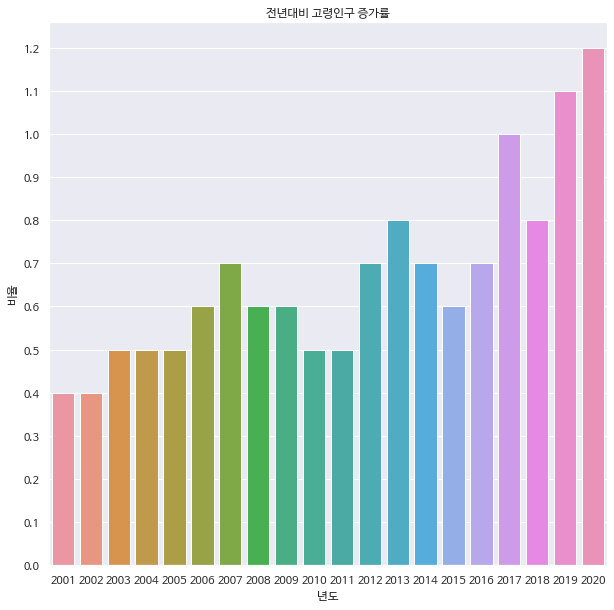

In [ ]:
plt.figure(figsize=(10,10))
sns.barplot(x=year,y=last)
plt.title("전년대비 고령인구 증가률")
plt.xlabel("년도")
plt.ylabel("비율")
plt.yticks([i for i in np.arange(0.0,1.3,0.1)])
plt.show()

## 6) 예측, 미래 고령인구 및 경로당 수 예측 
------

2001년 ~ 2020년의 고령인구 증가율을 참고하여 미래 증가될 고령인구를 예측

미래 고령인구 비율

$ FOP_{rate}(a,b,c,k_{time\,span}\,=\,e^{b+(a*x)}+c $

$k_{time\,span}\,=\,Y_{에측년도}\,-\,2001 $

$a\,=\,ln(2020년\,고령인구\,증가율\,/\,2001년\,고령인구\,증가율)\,/\,2020년\,-\,2001년 $

$b\,=\,ln(2001년\,고령인구\,증가율\,/\,a) $

$c\,=\,2001년\,고령인구\,비율\,-\,e^b $


###6.1) 미래 고령인구 비율 및 증가율 산출 메서드

In [ ]:
def future_old_population_rate_method(PGR_2001, Old_rate_2001, PGR_2020, x):
    '''
    미래 고령인구 비율 f(x) = np.exp(b+a*x)+c
    미래 고령인구 증가율 f'(x) = a*np.exp(b+a*x)
    :param PGR_2001 : 2001년 고령인구 증가율
    :param Old_rate_2001 : 2001년 고령인구 비율
    :param PGR_2020 : 2020년 고령인구 증가율
    :param x : 미래 년도 - 2001
    :return: f(x), f'(x)
    '''
    x = x - 2001
    a = np.log(PGR_2020/PGR_2001) / 19
    b = np.log(PGR_2001/a)
    c = (Old_rate_2001-np.exp(b))
    fx = round(np.exp(b+(a*x))+c, 3)
    fx_dot  = round(a*np.exp(b+(a*x)), 3)
    print(f"고령인구 비율 : {fx}%, 고령인구 증가율 : {fx_dot}%")

    return  fx,fx_dot

In [ ]:
PGR_2001 = last[0]
Old_rate_2001 = orginal[0]
PGR_2020 = last[-1]
T = 2030 ## 2030년 예측하기
future_old_population_rate,increase_old_population_rate = future_old_population_rate_method(PGR_2001, Old_rate_2001, PGR_2020, T) ## 2030년 고령인구 비율 예측

고령인구 비율 : 36.483%, 고령인구 증가율 : 2.139%


###6.2) 미래 증가될 고령인구 산출 메서드
----

$ 미래\,증가된\,고령인구\,=\,(미래\,고령인구\,비율\,/\,100) * 부산\,전체\,인구 $

$ 미래\,증가될\,고령인구\,=\,미래\,증가된\,고령인구\,-\,부산\,고령인구 $

In [ ]:
def predict_future_old_population(future_old_population_rate,df_population):
    '''
    예측된 미래 고령인구 비율을 이용하여 증가될 고령인구 수를 구한다
    :param future_old_population_rate: 미래 고령인구 비율
    :param df_population: 현재 인구 데이터
    :return: 미래 증가될 고령인구 수
    '''
    df = pd.DataFrame(columns=["행정 구","행정 동","증가될 인구","증가될 경로당 수"])
    future_old_population =  (future_old_population_rate / 100) * df_population.iloc[0]["합계"] # 증가된 고령 인구 수
    predict_future_old_population = round(future_old_population -  df_population.iloc[0]["고령인구 합계"])  # 증가될 고령 인구수 (증가된 고령 인구 - 현재 고령 인구)

    return predict_future_old_population

In [ ]:
future_old_population_by_busan = predict_future_old_population(future_old_population_rate,df_population)
future_old_population_by_busan

547269

### 6.3) 행정 동 단위 미래 증가될 고령인구 산출
-----
$ 행정\,동\,단위\,미래\,증가될\,고령인구\,=\,(부산\,행정\,동\,단위\,고령인구\,/\,부산\,고령인구)\, * \,미래\,증가될\,고령인구 $

In [ ]:
df_future_main =  get_senior_centers_by_district()
#df_request_member_main

In [ ]:
predict_future_old_population_by_admin_area = (
        (df_old_population_count.iloc[0:]["고령인구 합계"] / df_population.iloc[0]["고령인구 합계"]) * future_old_population_by_busan).reset_index()
predict_future_old_population_by_admin_area.head(5)

,행정구역(동읍면)별,고령인구 합계
0,가덕도동,956.003903
1,가락동,749.933746
2,가야1동,3506.425134
3,가야2동,3141.963799
4,감만1동,2771.845635


###6.4) 미래 행정 동 단위 적절한 경로당 수 산출 메서드
----
노인 1명당 필요한 경로당 개수는 현재 산출한 값을 사용

$ 행정\,동\,단위\,적절한\,경로당\,수\,=\,노인\,1명당\,필요한\,경로당\,개수\, * \,미래\,행정\,동\,단위\,증가될\,고령인구 $

In [ ]:
def future_old_population_sum_by_admin_area_advance_2(df_future_main,predict_future_old_population_by_admin_area,df_sc_members):
    '''
    미래의 행정 동 별 적절한 경로당 수를 구한다.
    :param df_future_main: 이용률을 고려한 데이터를 담을 df
    :param predict_future_old_population_by_admin_area: 미래 행정 동 단위 증가될 고령인구
    :param df_sc_members: 노인 1명당 필요한 경로당 개수 정보
    :return: 적절한 경로당 수가 추가된 데이터 프레임
    '''

    admin_area_n = df_sc_members.shape[0] # 행정 동 개수 205
    gu_n = predict_future_old_population_by_admin_area.shape[0] # 행정 구 개수 16개
    df_future_main.set_index(["행정 구"],inplace=True)
    district = ["강서구", "금정구","기장군","남구","동구","동래구","부산진구","북구","사상구","사하구","서구","수영구","연제구","영도구","중구","해운대구"]
    i = 0

    for d in district:
        df_future_main.loc[d,["노인 1명당 필요한 경로당 개수"]] = df_sc_members.loc[d]["노인 1명이 필요한 경로당 개수"]
        i += 1

    # 행정 동 적절한 경로당 수 구함

    df_future_main.reset_index(inplace=True)
    df_future_main = df_future_main.set_index("행정 동").sort_index()
    predict_future_old_population_by_admin_area.set_index("행정구역(동읍면)별",inplace=True)

    lst1 = np.array(df_future_main.iloc[0:]["노인 1명당 필요한 경로당 개수"])
    lst2 = np.array(predict_future_old_population_by_admin_area.iloc[0:]["고령인구 합계"])

    mul = lst1 * lst2
    mul = mul.astype(int)
    df_future_main["적절한 경로당 수"] = mul
    return df_future_main

In [ ]:
df_future_main = future_old_population_sum_by_admin_area_advance_2(df_future_main,predict_future_old_population_by_admin_area,df_sc_members)

In [ ]:
df_future_main.head(5)

,행정 구,경로당 수,적절한 경로당 수,필요한 경로당 수,노인 1명당 필요한 경로당 개수
행정 동,,,,,
가덕도동,강서구,NaN,10,NaN,0.011369
가락동,강서구,NaN,8,NaN,0.011369
가야1동,부산진구,NaN,16,NaN,0.004702
가야2동,부산진구,NaN,14,NaN,0.004702
감만1동,남구,NaN,8,NaN,0.002941


### 6.5) 미래 Main 데이터 프레임 컬럼명 변경 및 미래 필요한 경로당 수 산출 메서드
----

필요한 경로당 수 -> 미래 필요한 경로당 수

적절한 경로당 수 -> 증가될 경로당 수

$ 미래\,필요한\,경로당\,수\,=\,증가될\,경로당\,수\, + \,현재\,필요한\,경로당\,수 $

In [ ]:

def complete_it(df_future_main,predict_future_old_population_by_admin_area,df_extract_main):
    '''
    증가될 인구 및 미래 필요한 경로당 수, 증가될 경로당 수를 산출하여 리턴한다.
    :param df_future_main: 미래의 데이터를 가짐
    :param predict_future_old_population_by_admin_area: 미래의 고령인구
    :param df_extract_main: 현재의 필요한 경로당 수가 추출된 데이터
    :return: 행정 동 | 행정 구 | 증가될 경로당 수 | 미래 필요한 경로당 수 | 노인 1명당 필요한 경로당 개수 | 증가될 인구
    '''
    df_future_main["증가될 인구"] = round(predict_future_old_population_by_admin_area.iloc[0:]["고령인구 합계"], 0).astype(int)
    df_future_main = df_future_main.drop(columns=["경로당 수"])
    df_future_main = df_future_main.rename(columns={"필요한 경로당 수": "미래 필요한 경로당 수", "적절한 경로당 수": "증가될 경로당 수"})
    df_extract_main = df_extract_main.set_index("행정 동").sort_index()
    # 미래의 적절한 경로당 + 현재의 필요한 경로당 수
    df_future_main["미래 필요한 경로당 수"] = df_future_main.iloc[0:]["증가될 경로당 수"] + df_extract_main.iloc[0:]["필요한 경로당 수"]

    return df_future_main

In [ ]:
df_future_main = complete_it(df_future_main,predict_future_old_population_by_admin_area,df_extract_main)

NameError: ignored

In [ ]:
df_future_main.head(5)

# [2] 모델링 - 시니어 센터가 시급하게 요구되는 후보지 기준
------
경로당을 미리 증설하여 증가하는 고령 인구와 지역별 이용률에 맞는 
수요와 공급을 즉각 만족하기 위해

__미래 필요한 경로당 수 상위 4개 행정 동__을 경로당이 시급하게 필요한 후보지로 설정.




## 1) 시각화

###1.1) 미래 필요한 경로당 수 상위4개 행정 동 시각화 메서드

In [ ]:
def drawing_future_senior_center_by_admin_area(df_future_main):
    option = df_future_main["미래 필요한 경로당 수"]>= 50
    df_condition = df_future_main.loc[option]
    df_condition.reset_index().sort_values(by="미래 필요한 경로당 수")

    plt.xlabel("행정 동")
    plt.ylabel("개소")
    sns.barplot(x=df_condition.index,y="미래 필요한 경로당 수",data=df_condition.tail(4))
    # plt.savefig("year_orginal.png")
    return plt.show()

In [ ]:
drawing_future_senior_center_by_admin_area(df_future_main)

NameError: ignored

- 최적의 입지를 위한 고려사항
----
노인의 __이동수단과 시간__을 고려했을 때 __걸어서 10분 이내의 위치가 최적__ 입지라고 선정.

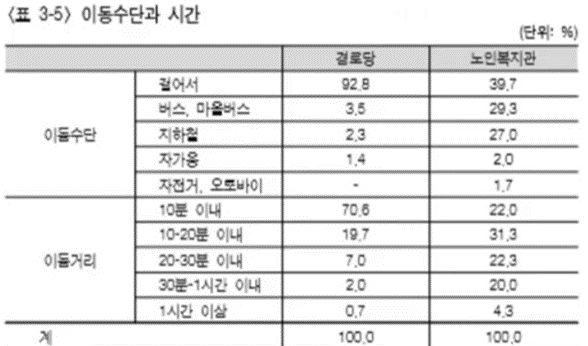


### 1.2) 도보 기준 네트워크 중심성 및 이동시간에 따른 영역 시각화
----

걸어서 10분 이내의 위치 시각화를 위한 네트워크 설계

In [ ]:
hwy_colors = {'footway': 'skyblue', ## 차도 옆 보도
              'residential': 'red', ## 주택가
              'living street': 'green', ## 생활가
              'secondary': 'grey',
              'pedestrian': 'orange'} ## 보행자 도로

## 2) 메서드

###2.1) 후보지의 거리 네트워크 엣지를 탐색 메서드

In [ ]:
# 엣지를 탐색
def find_edges(G, hwys):
    edges = []
    for u, v, k, data in G.edges(keys=True, data='highway'):
        check1 = isinstance(data, str) and data not in hwys
        check2 = isinstance(data, list) and all([d not in hwys for d in data])
        if check1 or check2:
            edges.append((u, v, k))
    return set(edges)

### 2.2) 후보지의 거리 네트워크를 시각화 메서드

In [ ]:
def drawing(G,hwy):
    G_tmp = G.copy()
    G_tmp.remove_edges_from(G.edges - find_edges(G, hwy_colors.keys()))
    m = ox.plot_graph_folium(G_tmp, popup_attribute='highway', weight=2, color='black')

    for hwy, color in hwy_colors.items():
        G_tmp = G.copy()
        G_tmp.remove_edges_from(find_edges(G_tmp, [hwy]))
        if G_tmp.edges:
            m = ox.plot_graph_folium(G_tmp,
                                     graph_map=m,
                                     popup_attribute='highway',
                                     weight=2,
                                     color=color)
    return m

### 2.3) 후보지의 거리네트워크 중심성 파악 메서드
------
사용한 centrality 알고리즘

closeness_centrality : 동시에 가장 짧은 시간에 도달 가능한 위치 파악에 적합



In [ ]:
def center(G):
    edge_centrality = nx.closeness_centrality(nx.line_graph(G)) ##closeness centrality 사용 이유 동시에 가장 짧은 시간에 도달 가능한 위치 파악.
    nx.set_edge_attributes(G, edge_centrality, "edge_centrality")
    ec = ox.plot.get_edge_colors_by_attr(G, "edge_centrality", cmap="inferno")
    fig, ax = ox.plot_graph(G, edge_color=ec, edge_linewidth=2, node_size=0)
    return  fig,ax

### 2.4) 이동시간에 따른 영역 시각화 메서드
-----

- 노란색 : 5분 이내
- 주황생 : 10분 이내

In [ ]:
def find_ten_min(G,x,y):

    network_type = "walk"
    trip_times = [5, 10, 15, 20, 25, 30]  # 분 단위의 여행시간, 5분거리내
    travel_speed = 3.5  # 걷는 속도 (km/hour)

    gdf_nodes = ox.graph_to_gdfs(G, edges=False)
    # x, y = gdf_nodes["geometry"].unary_union.centroid.xy # 지도 중심점 좌표
    #  [35.23876594878238, 129.21575390899562] # 기장읍 행정복지 센터
    center_node = ox.distance.nearest_nodes(G, x, y)
    G = ox.project_graph(G)
    meters_per_minute = travel_speed * 1000 / 60

    #고도 데이터가 아직 없기때문에 주석처리 해놓겠습니다.
    #Slope_way = 3.5 + 0.1 * meters_per_minute + 1.8 * meters_per_minute * data[경사도] # 경사가 있는 길의 산소 호흡량(칼로리 소모량)
    #Flat_way = 3.5 + 0.1 * meters_per_minute # 경사가 없는 평지의 산소 호흡량(칼로리 소모량)
    #Diff_Percentage_Slope_and_Flat_Way = Slope_way / Flat_way # 경사로와 평지의 칼로리 차이를 퍼센트로 나타냄

    for _, _, _, data in G.edges(data=True, keys=True):
        #data["time"] = data["length"] * Diff_Percentage_Slope_and_Flat_Way / meters_per_minute # 칼로리 퍼센트를 곱해줌으로써 이동거리에 경사로를 대입

        data["time"] = data["length"] / meters_per_minute
        iso_colors = ox.plot.get_colors(n=len(trip_times), cmap="plasma", start=0, return_hex=True)
        # 등시성에 따라 노드에 색칠
    node_colors = {}
    for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
        subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance="time")
        for node in subgraph.nodes():
            node_colors[node] = color
    nc = [node_colors[node] if node in node_colors else "none" for node in G.nodes()]
    ns = [15 if node in node_colors else 0 for node in G.nodes()]
    fig, ax = ox.plot_graph(
        G,
        node_color=nc,
        node_size=ns,
        node_alpha=0.8,
        edge_linewidth=0.2,
        edge_color="#999999",
    )
    return plt.show()

##3) 후보지 주소,좌표 및 네트워크 타입 설정

In [ ]:

kizang_pos= [35.23876594878238, 129.21575390899562] ## 기장읍 사무소
Jeonggwan_pos = [35.3231, 129.1784] # 정관읍 윗골공원
Noksan_pos= [35.08562495305441, 128.87931646088754]
Myungji_pos = [35.10820208025592, 128.9264932285998]
network_type = "walk" # 걷기

In [ ]:
kizang = "기장읍, 기장군, 부산, 대한민국"
Jeonggwan = "정관읍, 기장군, 부산, 대한민국"
Noksan = "녹산동, 강서구, 부산, 대한민국"
Myungji = "명지동, 강서구,부산, 대한민국"

## 4) 후보지 네트워크 생성

In [ ]:
G_kizang  = ox.graph_from_place(kizang,network_type=network_type)
G_Jeonggwan  = ox.graph_from_place(Jeonggwan,network_type=network_type)
G_Noksan  = ox.graph_from_place(Noksan,network_type=network_type)
G_Myungji  = ox.graph_from_place(Myungji,network_type=network_type)

# [3] 시니어 센터가 필요한 입지 분석 결과

## 1) 부산 기장군 기장읍

### 1.1) 기장읍 도보기준 네트워크

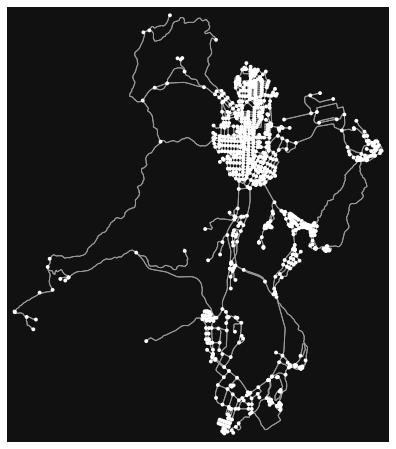

In [ ]:
fig, ax = ox.plot_graph(G_kizang)

### 1.2) 기장읍 주거지 중심성 시각화

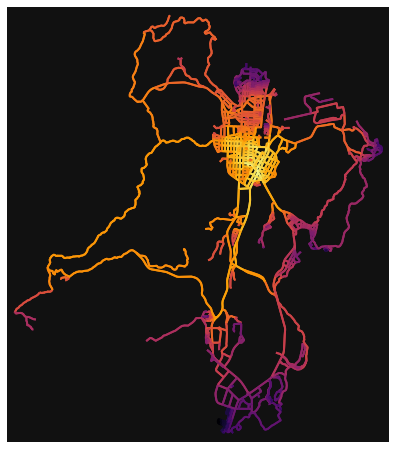

In [ ]:
fig,ax = center(G_kizang)

### 1.3) 기장읍 주거지 중심 이동거리에 따른 영역

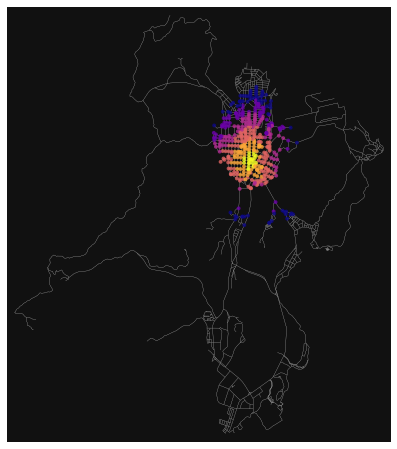

In [ ]:
find_ten_min(G_kizang,kizang_pos[1],kizang_pos[0])

## 2) 부산 기장군 정관읍

### 2.1) 정관읍 도보기준 네트워크

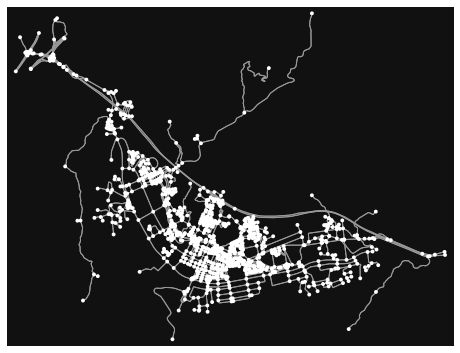

In [ ]:
fig2, ax2 = ox.plot_graph(G_Jeonggwan)

###2.2) 정관읍 주거지 중심성 시각화

In [ ]:
fig.ax = center(G_Jeonggwan)

NameError: ignored

###2.3) 정관읍 주거지 중심 이동거리에 따른 영역 시각화

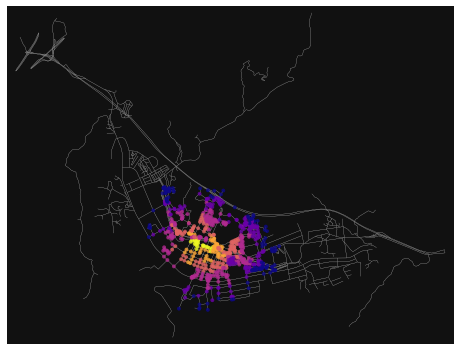

In [ ]:
find_ten_min(G_Jeonggwan,Jeonggwan_pos[1],Jeonggwan_pos[0])


## 3. 부산 강서구 녹산동

### 3.1) 녹산동 도보기준 네트워크

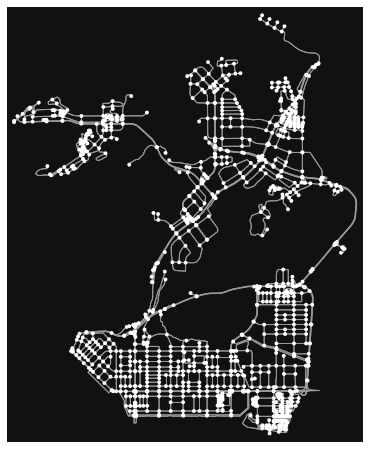

In [ ]:
fig3, ax3 = ox.plot_graph(G_Noksan)

###3.2) 녹산동 주거지 중심성 시각화

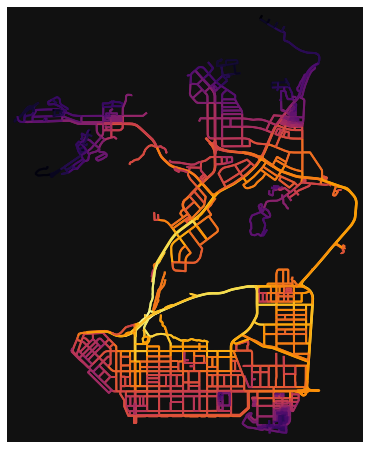

In [ ]:
fig,ax = center(G_Noksan)

### 3.3)녹산동 주거지 중심 이동거리에 따른 영역 시각화

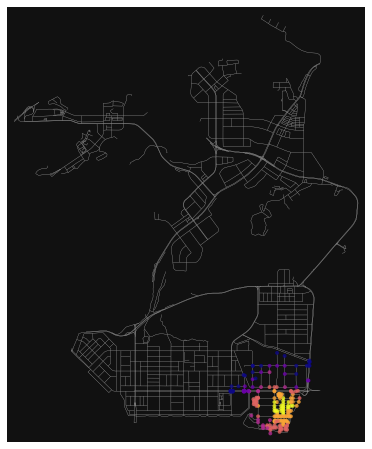

In [ ]:
find_ten_min(G_Noksan,Noksan_pos[1],Noksan_pos[0])

## 4) 부산 강서구 명지1동

### 4.1) 명지1동 도보기준 네트워크

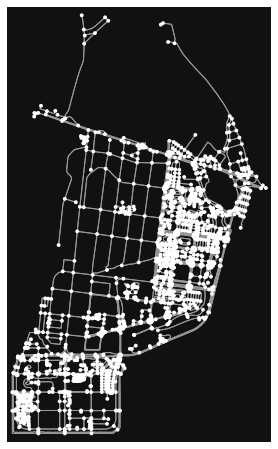

In [ ]:
fig4, ax4 = ox.plot_graph(G_Myungji)

###4.2) 명지1동 주거지 중심성 시각화

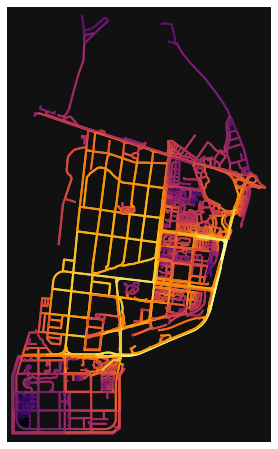

In [ ]:
fig,ax = center(G_Myungji)

###4.3) 명지1동 주거지 중심 이동거리에 따른 영역 시각화

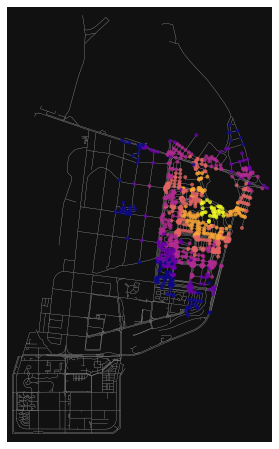

In [ ]:
find_ten_min(G_Myungji,Myungji_pos[1],Myungji_pos[0])